In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet
from pathlib import Path
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import calendar
import os
import missingno as msno
import datetime as dt
import time

In [5]:
def assign_cycle_vars(df, suffix, var_pos, var_cycle_length):
    df['sin_term_'+suffix] = np.sin(df[var_pos]/df[var_cycle_length])
    df['cos_term_'+suffix] = np.cos(df[var_pos]/df[var_cycle_length])
    return None
def days_between(d1, d2):
    d1 = dt.datetime.strptime(d1, "%Y-%m-%d")
    d2 = dt.datetime.strptime(d2, "%Y-%m-%d")
    return (d2 - d1).days+1
def logify(x):
    return np.log(x - np.min(x) + 1)
def create_last_valid_feature(df, groupby_col, apply_col):
    df[apply_col+'_last_valid'] = dat.groupby(groupby_col)[apply_col].apply(lambda x: x.shift(1))
    return None
def create_last_valid_features(df, groupby_col, apply_cols):
    for col in apply_cols:
        create_last_valid_feature(df, groupby_col, col)
    return None
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key',suffixes=['','']).drop('key', 1))


In [3]:
main_dir = Path('/Users/zach/Documents/git/thrasio')
data_dir = main_dir / 'Case_Study_Materials'
file_path = data_dir / 'CASE_STUDY_FINAL.csv'

In [4]:
dat_orig = pd.read_csv(file_path, low_memory=False)

In [21]:
dat_orig.dtypes

Date              object
SKU_mkt           object
Brand_ID           int64
Total_Units        int64
PPC_Units          int64
PPC_Cost         float64
Organic_Units      int64
dtype: object

In [19]:
dat_init = dat_orig.copy()

In [20]:
dat_init['datetime'] = pd.to_datetime(dat['Date'])

Create dimension tables for sku and date

In [21]:
dim_sku = pd.DataFrame(dat_init['SKU_mkt'].unique(),columns=['SKU_mkt'])

In [22]:
dim_sku['sku_num'] = list(range(dim_sku.shape[0]))

In [23]:
dim_date = pd.DataFrame(dat_init['datetime'].unique(),columns=['datetime'])

In [24]:
dim_date['date'] = dim_date['datetime'].dt.date
dim_date['year'] = dim_date['datetime'].dt.year
dim_date['month'] = dim_date['datetime'].dt.month
dim_date['dayofyear'] = dim_date['datetime'].dt.dayofyear
dim_date['dayofmonth'] = dim_date['datetime'].dt.day
dim_date['dayofweek'] = dim_date['datetime'].dt.weekday
dim_date['days_in_month'] = [calendar.monthrange(y,m)[1] for y,m in zip(dim_date['year'], dim_date['month'])]
dim_date['days_in_year'] = [366 if calendar.isleap(y) else 365 for y in dim_date['year']]
dim_date['days_in_week'] = 7
dim_date['year_month'] = [str(y)+'-'+str(m) if m > 9 else str(y)+'-0'+str(m) for y,m in zip(dim_date['year'], dim_date['month'])]
assign_cycle_vars(dim_date, 'fracofyear', 'dayofyear', 'days_in_year')
assign_cycle_vars(dim_date, 'fracofmonth', 'dayofmonth', 'days_in_month')
assign_cycle_vars(dim_date, 'fracofweek', 'dayofweek', 'days_in_week')

In [25]:
dim_date['day_ordinal'] = dim_date['datetime'].rank(method='dense')
dim_date['month_ordinal'] = dim_date['year_month'].rank(method='dense')
#TODO add weekenddates, monthenddate, yearenddate

In [26]:
# "previous" dates
dim_date['date_prior_day'] = dim_date['date'] - dt.timedelta(days=1)
dim_date['date_prior_week'] = dim_date['date'] - dt.timedelta(days=7)
dim_date['date_prior_year'] = dim_date['date'] - dt.timedelta(weeks=52)

Create skeleton

In [27]:
skel = cartesian_product_basic(dim_sku,dim_date)

Add dim table data to main dataset

In [29]:
dat = skel.merge(dat_init, how='left', on=['SKU_mkt','datetime'],suffixes=['',''])

In [35]:
dat['missing'] = (dat['Total_Units'].isna())*1

Inspect missingness

In [58]:
df_missing = dat[['sku_num','missing','day_ordinal']].copy()
df_missing_agg = df_missing.groupby('sku_num')['missing'].mean().reset_index(drop=False)
df_missing.sort_values(['day_ordinal','sku_num'])
df_missing_pivot = df_missing.pivot(index='sku_num',columns='day_ordinal',values='missing').reset_index(drop=False)
df_missing_pivot = df_missing_pivot.merge(df_missing_agg, how='left', on='sku_num')
df_missing_pivot.sort_values('missing', ascending=False,inplace=True)
df_missing_pivot

,sku_num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1099.0,1100.0,1101.0,1102.0,1103.0,1104.0,1105.0,1106.0,1107.0,missing
482,482,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0.901536
408,408,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.900632
411,411,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,0.891599
266,266,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.874435
418,418,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0.874435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.001807
5,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000903
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000903
8,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


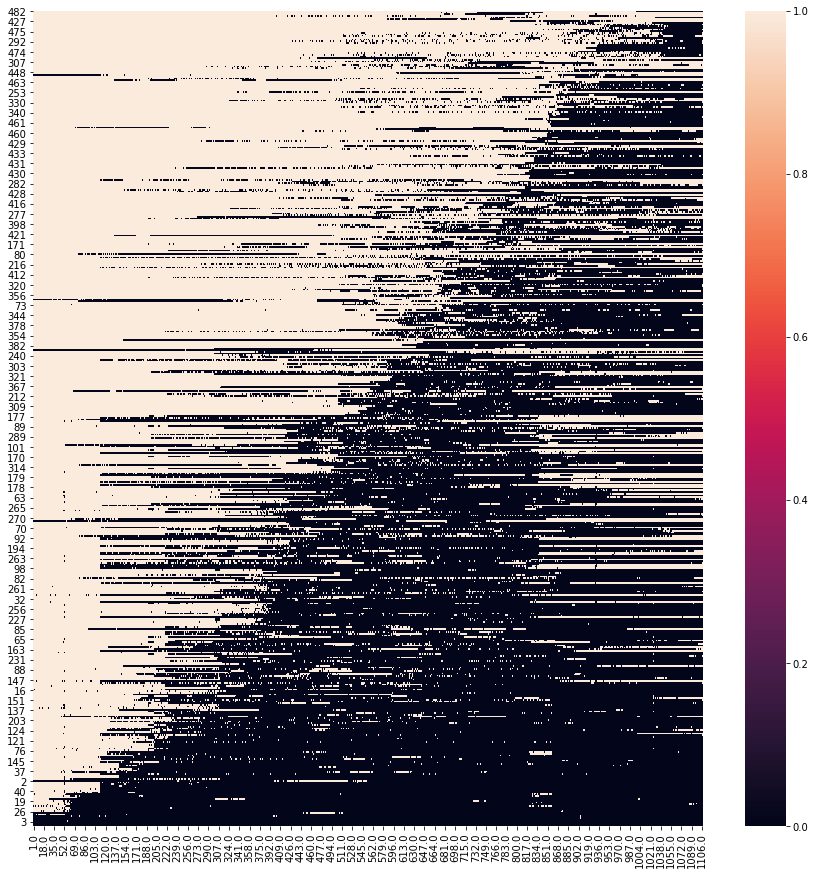

In [63]:
plt.figure(figsize=(15,15))
sns.heatmap(df_missing_pivot.drop(labels=['missing', 'sku_num'],axis=1))

Inspect sample size for each sku

In [521]:
dat_groupby_sku = pd.DataFrame(dat[['sku_num', 'date','Total_Units']].groupby('sku_num').agg(
    {
        'date':('count','min','max'),
        'Total_Units':('min', 'max', np.mean)
    }).reset_index(drop=False))
dat_groupby_date = pd.DataFrame(dat[['date','sku_num']].groupby('date').agg(
    {
        'sku_num':'nunique'
    }).reset_index(drop=False))

In [522]:
dat_groupby_sku.columns = ['sku_num', 'count_date','min_date','max_date', 'min_Total_Units', 'max_Total_Units','mean_Total_Units']
dat_groupby_sku.sort_values('count_date',ascending=False)

,sku_num,count_date,min_date,max_date,min_Total_Units,max_Total_Units,mean_Total_Units
4,4,1107,2017-01-01,2020-01-12,0,628,78.520325
8,8,1107,2017-01-01,2020-01-12,1,212,14.496838
3,3,1106,2017-01-01,2020-01-12,0,134,42.506329
5,5,1106,2017-01-01,2020-01-12,0,394,123.086799
6,6,1105,2017-01-01,2020-01-12,0,89,9.455204
...,...,...,...,...,...,...,...
418,418,139,2019-01-18,2020-01-12,0,9,1.661871
266,266,139,2018-01-13,2019-09-24,0,11,1.992806
411,411,120,2018-11-11,2020-01-10,0,29,9.250000
408,408,110,2018-11-07,2019-04-24,0,15,4.563636


In [524]:
dat_groupby_sku['count_expected_date'] = [days_between(str(d1),str(d2)) for d1,d2 in zip(dat_groupby_sku['min_date'], dat_groupby_sku['max_date'])]
dat_groupby_sku['sku_has_expected_dates'] = [1 if c1==c2 else 0 for c1,c2 in zip(dat_groupby_sku['count_date'], dat_groupby_sku['count_expected_date'])]

In [525]:
dat_groupby_sku[dat_groupby_sku['sku_has_expected_dates'] == 0]

,sku_num,count_date,min_date,max_date,min_Total_Units,max_Total_Units,mean_Total_Units,count_expected_date,sku_has_expected_dates
0,0,474,2017-01-01,2018-05-10,0,31,6.018987,495,0
1,1,215,2017-01-01,2019-09-27,0,371,7.418605,1000,0
2,2,974,2017-01-01,2020-01-12,0,84,15.203285,1107,0
3,3,1106,2017-01-01,2020-01-12,0,134,42.506329,1107,0
5,5,1106,2017-01-01,2020-01-12,0,394,123.086799,1107,0
...,...,...,...,...,...,...,...,...,...
475,475,161,2019-06-18,2020-01-12,0,78,8.316770,209,0
476,476,176,2019-07-01,2020-01-12,0,269,20.346591,196,0
479,479,174,2019-07-22,2020-01-12,1,31,10.637931,175,0
480,480,150,2019-07-28,2020-01-12,0,18,2.580000,169,0


In [526]:
#TODO correlations between PPC cost and PPC units/organic units

In [558]:
#TODO establish training/test data
#TODO prepare cross validation framework
#TODO implement naive model: predict previous day
#TODO install pystan or other hierarchical model

1107

In [568]:
dat['log_Total_Units'] = logify(dat['Total_Units'])
dat['log_Organic_Units'] = logify(dat['Organic_Units'])
dat['log_PPC_Units'] = logify(dat['PPC_Units'])
dat['PPC_Cost'] = abs(dat['PPC_Cost'])
dat['log_PPC_Cost'] = logify(dat['PPC_Cost'])
dat['PPC_Cost_per_unit'] = dat['PPC_Cost'] / (dat['PPC_Units']+1)

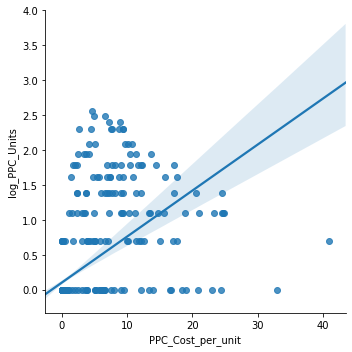

In [571]:
sns.lmplot(x='PPC_Cost_per_unit',y='log_PPC_Units',data=dat[dat['sku_num'] == 120])

In [541]:
dat = dat.merge(dat[['sku_num','date','Total_Units','Organic_Units','PPC_Units','log_Total_Units','log_Organic_Units','log_PPC_Units']], how='left',
                      left_on=('sku_num','date_prior_day'), right_on=('sku_num','date'), suffixes=['','_prior_day'])


In [544]:
dat.sort_values(['sku_num','date'],inplace=True)

In [545]:
dat['Total_Units_last_valid'] = dat.groupby('sku_num')['Total_Units'].apply(lambda x: x.shift(1))

In [549]:
create_last_valid_features(dat,'sku_num',['Total_Units','Organic_Units','PPC_Units','log_Total_Units','log_Organic_Units','log_PPC_Units'])

,SKU_mkt,Brand_ID,Total_Units,PPC_Units,PPC_Cost,Organic_Units,datetime,sku_num,date,year,...,PPC_Units_prior_day,log_Total_Units_prior_day,log_Organic_Units_prior_day,log_PPC_Units_prior_day,Total_Units_last_valid,Organic_Units_last_valid,PPC_Units_last_valid,log_Total_Units_last_valid,log_Organic_Units_last_valid,log_PPC_Units_last_valid
0,MODLB01GR1_US,1,1,1,7.30,0,2017-01-01,0,2017-01-01,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,MODLB01GR1_US,1,18,1,8.45,17,2017-01-02,0,2017-01-02,2017,...,1.0,0.693147,4.836282,0.693147,1.0,0.0,1.0,0.693147,4.836282,0.693147
27,MODLB01GR1_US,1,7,0,6.47,7,2017-01-03,0,2017-01-03,2017,...,1.0,2.944439,4.962845,0.693147,18.0,17.0,1.0,2.944439,4.962845,0.693147
42,MODLB01GR1_US,1,4,2,8.65,2,2017-01-04,0,2017-01-04,2017,...,0.0,2.079442,4.890349,0.000000,7.0,7.0,0.0,2.079442,4.890349,0.000000
58,MODLB01GR1_US,1,10,1,8.19,9,2017-01-05,0,2017-01-05,2017,...,2.0,1.609438,4.852030,1.098612,4.0,2.0,2.0,1.609438,4.852030,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,MODLB01GR1_US,1,5,1,5.34,4,2017-04-06,0,2017-04-06,2017,...,2.0,1.945910,4.867534,1.098612,6.0,4.0,2.0,1.945910,4.867534,1.098612
2102,MODLB01GR1_US,1,3,2,3.70,1,2017-04-07,0,2017-04-07,2017,...,1.0,1.791759,4.867534,0.693147,5.0,4.0,1.0,1.791759,4.867534,0.693147
2138,MODLB01GR1_US,1,4,2,9.39,2,2017-04-08,0,2017-04-08,2017,...,2.0,1.386294,4.844187,1.098612,3.0,1.0,2.0,1.386294,4.844187,1.098612
2175,MODLB01GR1_US,1,7,4,15.05,3,2017-04-09,0,2017-04-09,2017,...,2.0,1.609438,4.852030,1.098612,4.0,2.0,2.0,1.609438,4.852030,1.098612
